In [1]:
!pwd

/home/alan_khang/dev/mmdeploy


In [1]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

from mmdeploy.apis.utils import build_task_processor
from mmdeploy.utils import get_input_shape, load_config

from mmdet3d.visualization.vis_utils import proj_camera_bbox3d_to_img
from mmdet3d.structures import Det3DDataSample

from mmengine.visualization.utils import tensor2ndarray
from mmengine.structures import InstanceData

deploy_file_cfg = './configs/mmdet3d/monocular-detection/fcos3d_adam_tensorrt_static-416x640.py'
model_cfg = '/home/alan_khang/dev/mmdetection3d/work_dirs/fcos3d_adam/fcos3d_r101-caffe-dcn_fpn_head-gn_8xb2-1x_adam-mono3d.py'
device = 'cuda:0'
backend_model = ['work_dir/mmdet3d/fcos3d/end2end.engine']
image_path = '/home/alan_khang/Downloads/guilder_dataset/images/frame_000000.jpg'
image = cv2.imread(image_path)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
assert image is not None, f"Image not found at {image_path}"

deploy_cfg, model_cfg = load_config(deploy_file_cfg, model_cfg)

# build task and backend model
task_processor = build_task_processor(model_cfg, deploy_cfg, device)
model = task_processor.build_backend_model(backend_model)

# process input image
input_shape = get_input_shape(deploy_cfg)
model_inputs, _ = task_processor.create_input(image, input_shape)

# do model inference
with torch.no_grad():
    result = model.test_step(model_inputs)[0]

if isinstance(result, dict): 
    metadata = model_inputs['data_samples'][0].metainfo
    pred_instances_3d = InstanceData(metainfo=metadata)
    pred_instances_3d.bboxes_3d = result['img_bbox']['bboxes_3d']
    pred_instances_3d.labels_3d = result['img_bbox']['labels_3d']
    pred_instances_3d.scores_3d= result['img_bbox']['scores_3d']
    result = Det3DDataSample(metainfo=metadata)
    result.pred_instances_3d = pred_instances_3d


07/26 18:56:12 - mmengine - WARNING - Failed to search registry with scope "mmdet3d" in the "Codebases" registry tree. As a workaround, the current "Codebases" registry in "mmdeploy" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmdet3d" is a correct scope, or whether the registry is initialized.
07/26 18:56:12 - mmengine - WARNING - Failed to search registry with scope "mmdet3d" in the "mmdet3d_tasks" registry tree. As a workaround, the current "mmdet3d_tasks" registry in "mmdeploy" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmdet3d" is a correct scope, or whether the registry is initialized.
07/26 18:56:12 - mmengine - WARNING - Failed to search registry with scope "mmdet3d" in the "backend_mono_detectors" registry tree. As a workaround, the current "backend_mono_detectors" registry in "mmdeploy" is used to build instance. This may cause unexpec

In [7]:
result.pred_instances_3d.bboxes_3d.tensor[0]

tensor([0.1755, 0.0730, 0.9780, 0.5137, 0.3359, 0.5815, 4.7109, 0.0765, 0.0086])

In [4]:
from mmdet3d.structures import Box3DMode, get_box_type, Det3DDataSample
from mmdet3d.models import (Base3DDetector, Base3DSegmentor,
                            SingleStageMono3DDetector)
from mmdet3d.visualization.vis_utils import proj_camera_bbox3d_to_img

In [5]:
bbox_palettes = [
    (255, 158, 0),  # Orange
    (255, 99, 71),  # Tomato
    (255, 140, 0),  # Darkorange
    (255, 127, 80),  # Coral
    (233, 150, 70),  # Darksalmon
    (220, 20, 60),  # Crimson
    (255, 61, 99),  # Red
    (0, 0, 230),  # Blue
    (47, 79, 79),  # Darkslategrey
    (112, 128, 144),  # Slategrey
]

bboxes_3d = result.pred_instances_3d.bboxes_3d 
labels_3d = result.pred_instances_3d.labels_3d
input_meta = result.metainfo

corners_2d = proj_camera_bbox3d_to_img(bboxes_3d, input_meta)

# Color
img_size = image.shape[:2][::-1]  # (width, height)
edge_colors = [bbox_palettes[label] for label in labels_3d]
edge_colors_norm = []
for color in edge_colors:
    assert len(color) == 3
    for channel in color:
        assert 0 <= channel <= 255
    color = [channel / 255 for channel in color]
    edge_colors_norm.append(tuple(color))

valid_point_idx = (corners_2d[..., 0] >= 0) & \
    (corners_2d[..., 0] <= img_size[0]) & \
    (corners_2d[..., 1] >= 0) & (corners_2d[..., 1] <= img_size[1])
valid_bbox_idx = valid_point_idx.sum(axis=-1) >= 4
corners_2d = corners_2d[valid_bbox_idx]
filter_edge_colors = []
filter_edge_colors_norm = []
for i, color in enumerate(edge_colors):
    if valid_bbox_idx[i]:
        filter_edge_colors.append(color)
        filter_edge_colors_norm.append(edge_colors_norm[i])
edge_colors = filter_edge_colors
edge_colors_norm = filter_edge_colors_norm

In [ ]:
image = cv2.imread(image_path)[..., ::-1]  # Convert BGR to RGB
image = np.ascontiguousarray(image)
overlay = image.copy()

def draw_rect(selected_corners, color):
    prev = selected_corners[-1]
    for corner in selected_corners:
        axis.plot([prev[0], corner[0]], [prev[1], corner[1]], color=color, linewidth=linewidth)
        prev = corner

alpha = 0.4

for i, corner_2d in enumerate(corners_2d):
    if i == 1:
        break
    corner_2d = corner_2d.astype(np.int32)
    front = corner_2d[4:]
    rear = corner_2d[:4]
    cv2.fillPoly(overlay, [front], color=edge_colors[i])
    cv2.polylines(overlay, [rear], isClosed=True, color=edge_colors[i], thickness=2)
    for j in range(4):
        cv2.line(overlay, tuple(front[j]), tuple(rear[j]), color=edge_colors[i], thickness=2)
    prev = front[-1]
    for corner in front:
        cv2.line(overlay, tuple(prev), tuple(corner), color=(0, 0, 0), thickness=2)
        prev = corner

image_new = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)

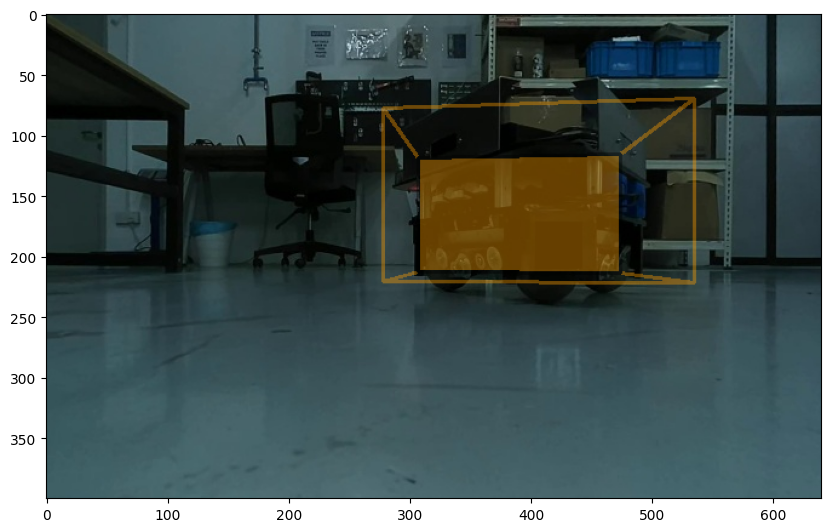

In [30]:
_ = plt.figure(figsize=(10, 10))

plt.imshow(image_new)